In [1]:
import jax
import jax.numpy as jnp
# Set double precision
jax.config.update("jax_enable_x64", True)
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_affine_set
from jax.experimental.ode import odeint
import numpy as np
import cvxpy as cp
from functools import partial
from sklearn.utils.extmath import randomized_svd
from utils.ssm import DelaySSM
from utils.plotting import plot_trajectories, plot_slow_fast_results
from utils.misc import polynomial_features, trajectories_derivatives

# Simulate simple, well-understood toy system

\begin{gathered}
\dot{x}_1=\lambda x_1\left(1-x_1^2\right) \\
\varepsilon \dot{x}_2=x_1^2-x_2
\end{gathered}

In [2]:
# Define the example slow-fast system
def slow_fast_system(x, t, λ, ε):
    x1, x2 = x
    dx1dt = λ * x1 * (1 - x1**2)
    dx2dt = (x1**2 - x2) / ε
    return jnp.array([dx1dt, dx2dt])


# Parameters (as in the paper)
λ = 0.1         # positive constant λ
ε = 0.1         # small positive constant ε (1/ε >> λ)
args = (λ, ε)

# Collect data

INFO   2025-04-08 21:55:26 xla_bridge Unable to initialize backend 'cuda': 


INFO   2025-04-08 21:55:26 xla_bridge Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO   2025-04-08 21:55:26 xla_bridge Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


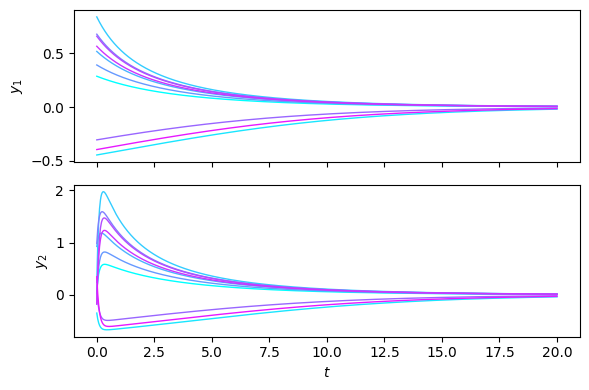

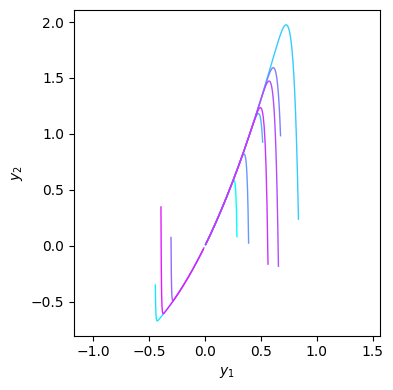

In [3]:
# Time points for integration
T = 20.0       # total time
N = 1000       # number of time points
ts = jnp.linspace(0, T, N)

# Simulate the system for several random initial conditions
rnd_key = jax.random.PRNGKey(0)
N_train = 10
x0s = jax.random.uniform(rnd_key, shape=(2, N_train), minval=0.5, maxval=2.0)
train_trajs = []
for i in range(N_train):
    x0 = x0s[:, i]
    xs = odeint(slow_fast_system, x0, ts, *args, rtol=1e-9, atol=1e-9, mxstep=10000)
    train_trajs.append(xs.T)
train_trajs = jnp.array(train_trajs)

# Center data such that the (1,1) equilibrium point is the origin
train_trajs -= jnp.array([[1.0, 1.0]]).reshape(1, 2, 1)

plot_trajectories(train_trajs, ts)

# Find optimal (oblique) linear projection

Here, we can directly perform optimization according to Equation (31) from the paper:
$$
\begin{aligned}
\min _{\mathbf{V}_{\text {opt}}, \mathbf{R}} & \quad \left\|\mathbf{V}_{\text {opt}}^{\top} \dot{\mathcal{Y}}-\mathbf{R}\left(\mathbf{V}_{\text{opt}}^{\top} \mathcal{Y}\right)^{1: n_r}\right\|^2 \\
\text{s.t.} & \quad \mathbf{V}_{\text{opt}}^{\top} \mathbf{V}_{\mathrm{E}}=\mathbf{I},
\end{aligned}
$$
such that we find the optimal (linear) projection and reduced dynamics right away.

In [4]:
# Hyperparameters
n = 1     # dimension of the slow manifold
n_r = 2   # polynomial order of reduced dynamics
n_w = 3   # polynomial order of parameterization map

# We obtain the number of polynomial features for the given order for the reduced dynamics
m_r = polynomial_features(jnp.zeros(n), n_r, 1).shape[1]

# Data
p = train_trajs.shape[1]
Y = train_trajs.transpose(1, 0, 2).reshape(p, -1)  # p x N_traj*len(t) := p x N
Y_dot = trajectories_derivatives(train_trajs, ts)
Y_dot = Y_dot.transpose(1, 0, 2).reshape(p, -1)  # p x N_traj*len(t) := p x N


def objective(VR):
    V_opt = VR[:p]  # p x n
    R = VR[p:].T  # n x m_r

    VY = V_opt.T @ Y  # n x N
    V_dotY = V_opt.T @ Y_dot  # n x N
    Phi = polynomial_features(VY.T, n_r, 1).T  # m_r x N

    # Compute residual
    residual = V_dotY - jnp.dot(R, Phi)  # p x N

    # Return Frobenius norm squared
    cost = jnp.sum(residual ** 2)
    return cost


# We get V_E using SVD on the data
V_E, _, _ = randomized_svd(np.asarray(Y), n_components=n)

# We use JAXOPT to do projected gradient descent
optimizer = ProjectedGradient(fun=objective, projection=projection_affine_set)
A_constraint = jnp.hstack([V_E.T, jnp.zeros((n, m_r))])
b_constraint = jnp.eye(n)
result = optimizer.run(init_params=jnp.zeros((p+m_r, n)), hyperparams_proj=(A_constraint, b_constraint))
V_opt = result.params[:p]
R_opt = result.params[p:].T
print('Solved in ', result.state.iter_num, ' iterations')

Solved in  53  iterations


Next we solve for the parameterization map, i.e.

$$
\begin{aligned}
\min _{\mathbf{W}_{\mathrm{nl}}} & \quad \left\|\mathcal{Y}-\mathbf{V}_{\mathrm{E}}\left(\mathbf{V}_{\text {opt}}^{\top} \mathcal{Y}\right)-\mathbf{W}_{\mathrm{nl}}\left(\mathbf{V}_{\text {opt}}^{\top} \mathcal{Y}\right)^{2: n_w}\right\|^2 \\
\text {s.t.} & \quad \mathbf{V}_{\text{opt}}^{\top} \mathbf{W}_{\mathrm{nl}}=\mathbf{0}
\end{aligned}
$$

In [5]:
m_w = polynomial_features(Y.T @ V_opt, n_w, 2).shape[1]
W_nl = cp.Variable((p, m_w))
param_objective = cp.Minimize(
            cp.sum_squares(Y - V_E @ V_opt.T @ Y - W_nl @ polynomial_features(Y.T @ V_opt, n_w, 2).T)
            )
constraints = [V_opt.T @ W_nl == jnp.zeros((n, m_w))]
problem = cp.Problem(param_objective, constraints)
problem.solve()
W_nl_opt = jnp.array(W_nl.value)
print('Status: ', problem.status)

Status:  optimal


# Benchmark again SSM with orthogonal projection

In [6]:
delay_ssm = DelaySSM(aut_trajs_obs=train_trajs,
                     SSMDim=1,
                     SSMOrder=2,
                     ROMOrder=2,
                     N_delay=0,
                     N_obs_delay=None,  # no reparametrization
                     ts=ts,
                     orthogonalize=True)  # orthogonalize the basis functions

INFO   2025-04-08 21:55:29 ridge Transforming data
INFO   2025-04-08 21:55:29 ridge Skipping CV on ridge regression
INFO   2025-04-08 21:55:29 ridge Fitting regression model
INFO   2025-04-08 21:55:29 ridge Transforming data
INFO   2025-04-08 21:55:29 ridge Skipping CV on ridge regression
INFO   2025-04-08 21:55:29 ridge Fitting regression model
INFO   2025-04-08 21:55:29 ridge Transforming data
INFO   2025-04-08 21:55:29 ridge Skipping CV on ridge regression
INFO   2025-04-08 21:55:29 ridge Fitting regression model


In [7]:
# Define test point
x0 = jnp.array([0.75, 1.75])
y0 = x0 - jnp.ones(2)

ts_plot = jnp.linspace(0, 60, 3000)

# Integrate the true system using odeint with high accuracy
x_true = odeint(slow_fast_system, x0, ts_plot, *args, rtol=1e-9, atol=1e-9, mxstep=10000)

# Obtain predictions of the SSM for x0
xr0_orth = delay_ssm.encode(y0)
xr_pred_orth = delay_ssm.simulate_reduced(xr0_orth, ts_plot)
y_pred_orth = delay_ssm.decode(xr_pred_orth)
x_pred_orth = y_pred_orth + jnp.ones((2, len(ts_plot)))

def continuous_reduced_dynamics(xr, R, n_r):
    xr = xr.reshape(1, -1)
    return R @ polynomial_features(xr, n_r, 1).T

# Obtain predictions of the updated SSM for x0
xr0_opt = V_opt.T @ (y0)
xr_pred_opt = odeint(lambda xr, _: partial(continuous_reduced_dynamics, R=R_opt, n_r=n_r)(xr), xr0_opt, ts_plot).T
y_pred_opt = V_E @ xr_pred_opt + W_nl_opt @ polynomial_features(xr_pred_opt.T, n_w, 2).T
x_pred_opt = y_pred_opt + jnp.ones((2, len(ts_plot)))

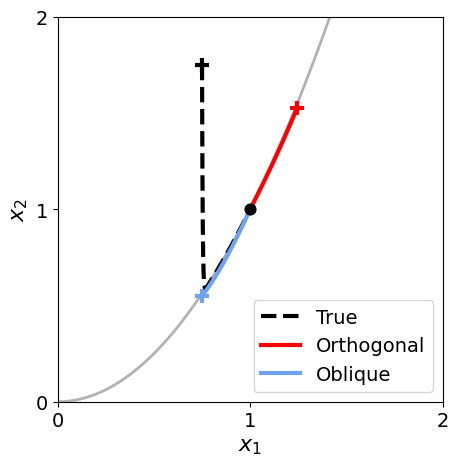

In [8]:
# Plot the results
plot_slow_fast_results(x_true, x_pred_orth, x_pred_opt)

# Add control input to the system

\begin{gathered}
\dot{x}_1 = \lambda x_1 \left(1 - x_1^2\right) + \alpha u_1 \\
\varepsilon \dot{x}_2 = x_1^2 - x_2 + \varepsilon \beta u_2 \\
\end{gathered}

In [9]:
# Define control inputs as a function of time
u_func = lambda t: jnp.array([jnp.exp(-t/1), jnp.exp(-t/1)])

# Define the controlled slow-fast system
def slow_fast_system_forced(x, t, λ, ε, α, β):
    x1, x2 = x
    u1, u2 = u_func(t)
    dx1dt = λ * x1 * (1 - x1**2) + α * u1
    dx2dt = (x1**2 - x2) / ε + β * u2
    return jnp.array([dx1dt, dx2dt])


# Parameters
λ = 0.1         # positive constant λ
ε = 0.1         # small positive constant ε (1/ε >> λ)
α = 0.2         # first control gain
β = 0.2         # second control gain
args = (λ, ε, α, β)

In [10]:
# Initial conditions
x0 = jnp.array([1.25, 0.25])
y0 = x0 - jnp.ones(2)

# Time points for integration
T = 40.0       # total time
N = 2000       # number of time points
ts = jnp.linspace(0, T, N)

# Integrate the truesystem using odeint with high accuracy
x_true = odeint(slow_fast_system_forced, x0, ts, *args, rtol=1e-9, atol=1e-9, mxstep=10000)

B = jnp.diag(jnp.array([α, β]))  # control input matrix
def continuous_reduced_dynamics_ctrl(xr, t, R, n_r):
    xr = xr.reshape(1, -1)
    u = u_func(t).reshape(-1, 1)
    return R @ polynomial_features(xr, n_r, 1).T + V_opt.T @ B @ u

# Obtain predictions of the SSM for x0
xr0_orth = delay_ssm.encode(y0)
xr_pred_orth = odeint(lambda xr, t: delay_ssm.reduced_dynamics(xr) + delay_ssm.V.T @ B @ u_func(t), xr0_orth, ts).T
y_pred_orth = delay_ssm.decode(xr_pred_orth)
x_pred_orth = y_pred_orth + jnp.ones((2, len(ts)))

# Obtain predictions of the updated SSM for x0
xr0_opt = V_opt.T @ y0
xr_pred_opt = odeint(lambda xr, t: partial(continuous_reduced_dynamics_ctrl, R=R_opt, n_r=n_r)(xr, t), xr0_opt, ts).T
y_pred_opt = V_E @ xr_pred_opt + W_nl_opt @ polynomial_features(xr_pred_opt.T, n_w, 2).T
x_pred_opt = y_pred_opt + jnp.ones((2, len(ts)))

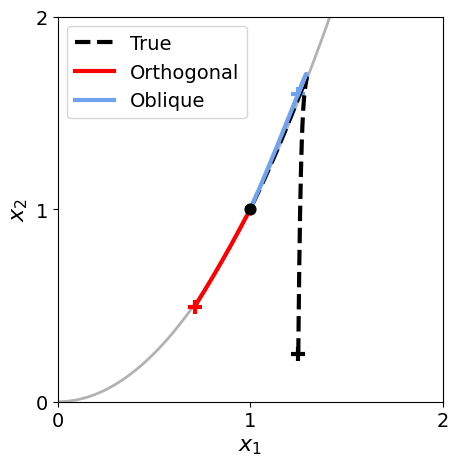

In [11]:
# Plot the results
plot_slow_fast_results(x_true, x_pred_orth, x_pred_opt)